In [27]:
import pandas as pd
from src.data.preprocess import clean_text

df = pd.read_csv(r"C:\Users\Arun\Documents\AI_projects\automatic_ticket_categorisation\data\raw\synthetic_complaints_new2.csv")

df["cleaned_text"] = df["complaint_text"].apply(clean_text)

df[["complaint_text", "cleaned_text"]].head(5)

,complaint_text,cleaned_text
0,Unable to link. my social media account to GAM...,unable link social medium account game respons...
1,<b>Payment failed but amount was deducted from...,payment fail amount deduct bank response support
2,I want to give feedback about the game need ur...,want give feedback game need urgent help
3,<b>The app experience has worsened after recen...,app experience worsen recent update happen las...
4,<i>Matchmaking is!! unfair and places me with ...,matchmaking unfair place high level player res...


In [2]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(PROJECT_ROOT)

print(PROJECT_ROOT)

C:\Users\Arun\Documents\AI_projects\automatic_ticket_categorisation


In [28]:
df.to_csv("../data/processed/cleaned_complaints_new2.csv", index=False)

In [29]:
df.head()

,complaint_id,complaint_text,category,submitted_via,created_date,cleaned_text
0,100000,Unable to link. my social media account to GAM...,Account Management,Chat,29-08-2024,unable link social medium account game respons...
1,100001,<b>Payment failed but amount was deducted from...,Billing,Email,29-07-2024,payment fail amount deduct bank response support
2,100002,I want to give feedback about the game need ur...,Other,Chat,01-09-2024,want give feedback game need urgent help
3,100003,<b>The app experience has worsened after recen...,Other,Chat,09-03-2024,app experience worsen recent update happen las...
4,100004,<i>Matchmaking is!! unfair and places me with ...,Product Issue,Website,11-10-2024,matchmaking unfair place high level player res...


In [30]:
df.isnull().sum()

complaint_id      0
complaint_text    0
category          0
submitted_via     0
created_date      0
cleaned_text      0
dtype: int64

In [31]:
df['category'].value_counts()

category
Account Management    5073
Other                 5026
Product Issue         4997
Billing               4987
Technical Support     4917
Name: count, dtype: int64

In [32]:
df["text_length"] = df["complaint_text"].str.split().apply(len)

In [33]:
df.head()

,complaint_id,complaint_text,category,submitted_via,created_date,cleaned_text,text_length
0,100000,Unable to link. my social media account to GAM...,Account Management,Chat,29-08-2024,unable link social medium account game respons...,13
1,100001,<b>Payment failed but amount was deducted from...,Billing,Email,29-07-2024,payment fail amount deduct bank response support,13
2,100002,I want to give feedback about the game need ur...,Other,Chat,01-09-2024,want give feedback game need urgent help,11
3,100003,<b>The app experience has worsened after recen...,Other,Chat,09-03-2024,app experience worsen recent update happen las...,14
4,100004,<i>Matchmaking is!! unfair and places me with ...,Product Issue,Website,11-10-2024,matchmaking unfair place high level player res...,14


In [34]:
df["text_length"].describe()

count    25000.000000
mean        11.135240
std          1.833719
min          7.000000
25%         10.000000
50%         11.000000
75%         12.000000
max         17.000000
Name: text_length, dtype: float64

In [35]:
from collections import Counter
all_words = " ".join(df["cleaned_text"]).split()
word_freq = Counter(all_words)

word_freq.most_common(20)

[('game', 13560),
 ('support', 6568),
 ('need', 5644),
 ('response', 5162),
 ('account', 5050),
 ('last', 5021),
 ('day', 5021),
 ('happen', 5018),
 ('unacceptable', 4990),
 ('urgent', 4942),
 ('help', 4942),
 ('please', 4885),
 ('resolve', 4885),
 ('asap', 4885),
 ('purchase', 2214),
 ('update', 2168),
 ('show', 2157),
 ('unable', 2150),
 ('progress', 2136),
 ('high', 2109)]

In [36]:
from sklearn.model_selection import train_test_split

X = df["cleaned_text"]
y = df["category"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),      # unigrams + bigrams
    min_df=2,               # ignore rare words
    max_df=0.9              # ignore very common words
)

In [38]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [39]:
X_train_tfidf.shape

(20000, 410)

In [40]:
import joblib
from pathlib import Path

MODEL_DIR = Path.cwd().parent / "models"
MODEL_DIR.mkdir(exist_ok=True)

joblib.dump(tfidf, MODEL_DIR / "tfidf_vectorizer_new2.pkl")

['C:\\Users\\Arun\\Documents\\AI_projects\\automatic_ticket_categorisation\\models\\tfidf_vectorizer_new2.pkl']

In [41]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",   # helps if classes are imbalanced
    n_jobs=-1
)


In [42]:
log_reg.fit(X_train_tfidf, y_train)

C:\Users\Arun\Documents\AI_projects\automatic_ticket_categorisation\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

In [43]:
y_pred = log_reg.predict(X_test_tfidf)

In [44]:
y_proba = log_reg.predict_proba(X_test_tfidf)

In [45]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

Account Management       1.00      1.00      1.00      1015
           Billing       1.00      1.00      1.00       997
             Other       1.00      1.00      1.00      1005
     Product Issue       1.00      1.00      1.00       999
 Technical Support       1.00      1.00      1.00       984

          accuracy                           1.00      5000
         macro avg       1.00      1.00      1.00      5000
      weighted avg       1.00      1.00      1.00      5000



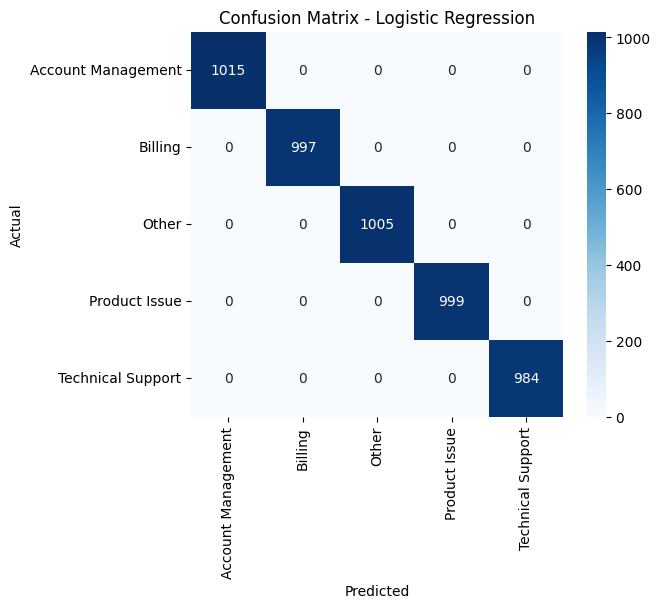

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=log_reg.classes_)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=log_reg.classes_,
            yticklabels=log_reg.classes_,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


In [47]:
MODEL_DIR = Path.cwd().parent / "models"
MODEL_DIR.mkdir(exist_ok=True)

joblib.dump(log_reg, MODEL_DIR / "logistic_regression_model_new2.pkl")

['C:\\Users\\Arun\\Documents\\AI_projects\\automatic_ticket_categorisation\\models\\logistic_regression_model_new2.pkl']

In [49]:
sample_text = "my refund has not been processed even after multiple follow ups"
# sample_text = "Poor service experience. kindly rectify."

sample_clean = sample_text  # assume cleaned if your pipeline already cleans input
sample_vec = tfidf.transform([sample_clean])

log_reg.predict(sample_vec)

array(['Billing'], dtype=object)